In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymdp
from pymdp import utils

In [2]:
# Specify the dimensionalities of the hidden state factors, 
# the control factors, and the observation modalities

context_names = ['Left-Better', 'Right-Better']
choice_names = ['Start', 'Left Arm', 'Right Arm']

""" Define `num_states` and `num_factors` below """
num_states = [len(context_names), len(choice_names)]
num_factors = len(num_states)

context_action_names = ['Do-nothing']
choice_action_names = ['Move-start', 'Play-left', 'Play-right']

""" Define `num_controls` below """
num_controls = [len(context_action_names), len(choice_action_names)]

reward_obs_names = ['Null', 'Loss', 'Reward']
choice_obs_names = ['Start', 'Left Arm', 'Right Arm']

""" Define `num_obs` and `num_modalities` below """
num_obs = [len(reward_obs_names), len(choice_obs_names)]
num_modalities = len(num_obs)

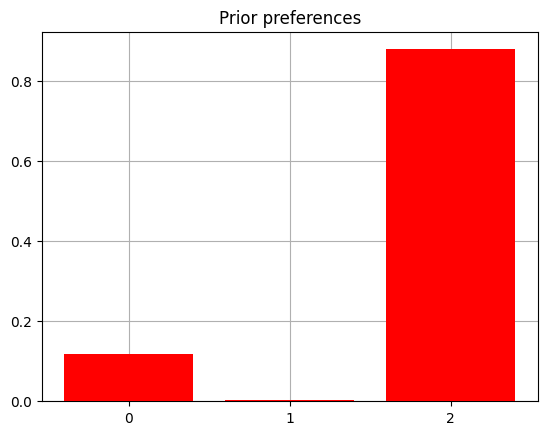

In [3]:
def create_A(p_reward=0.8):

    # initialize A
    A = utils.obj_array(num_modalities)

    A_reward = np.zeros((len(reward_obs_names), len(context_names), len(choice_names)))

    for choice_id, choice_name in enumerate(choice_names):
        if choice_name == 'Start':
            A_reward[0,:,choice_id] = 1.0
        
        elif choice_name == 'Left Arm':
            A_reward[1:,:,choice_id] = np.array([ [1.0-p_reward, p_reward], 
                                                [p_reward, 1.0-p_reward]])
        elif choice_name == 'Right Arm':
            A_reward[1:, :, choice_id] = np.array([[ p_reward, 1.0- p_reward], 
                                                [1- p_reward, p_reward]])
    
    A[0] = A_reward

    A_choice = np.zeros((len(choice_obs_names), len(context_names), len(choice_names)))

    for choice_id in range(len(choice_names)):
        A_choice[choice_id, :, choice_id] = 1.0

    A[1] = A_choice

    return A


def create_B(p_change=0.0):
    B = utils.initialize_empty_B(num_states, num_states)

    # Context transitions (uncontrollable) 
    B_context = np.zeros( (len(context_names), len(context_names), len(context_action_names)) )
    B_context[:,:,0] = np.array([[1.-p_change,    p_change], 
                                [p_change, 1.-p_change]]
                                )
    
    # Choice transitions (controllable)
    B_choice = np.zeros( (len(choice_names), len(choice_names), len(choice_action_names)) )
    for choice_i in range(len(choice_names)):
        B_choice[choice_i, :, choice_i] = 1.0

    B[0], B[1] = B_context, B_choice

    return B

from pymdp.maths import softmax

def create_C(reward=2., pun=-4.):
    """ Creates the C array, AKA the observation prior for the MAB task, parameterized by a `reward` and `pun` (punishment) parameter """

    C = utils.obj_array_zeros(num_obs)
    C[1] = np.array([0., pun, reward])
    return C


def create_D(p_context=0.5):
    """
    Creates the D array AKA the hidden state prior at the first timestep for the MAB task, parameterized by a `p_context` parameter that
    parameterizes the agent's prior beliefs about whether the context is "Left Arm Better" at the first timestep of a given trial
    """

    D = utils.obj_array(num_factors)

    """ Context prior """
    D_context = np.array([p_context, 1. - p_context])
    D[0] = D_context 


    """ Choice-state prior """
    D_choice = np.zeros(len(choice_names))
    D_choice[choice_names.index("Start")] = 1.0
    D[1] = D_choice

    return D




A = create_A()
B = create_B()
C = create_C(reward=2.0, pun=-4.0)
D = create_D()

utils.plot_beliefs(softmax(C[1]), title = "Prior preferences")

ie agent has preferences for winning

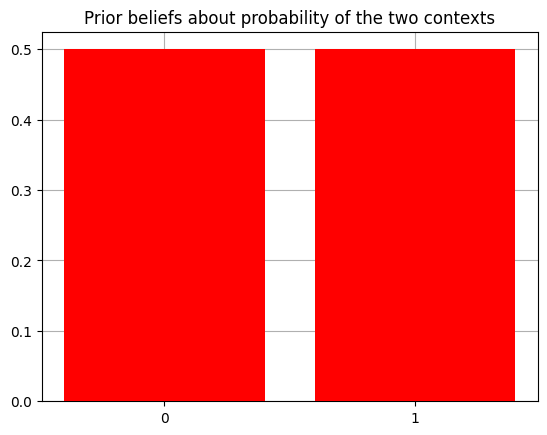

In [4]:
utils.plot_beliefs(softmax(D[0]), title = "Prior beliefs about probability of the two contexts")

flat priors to begin with

In [5]:
class TwoArmedBandit:

  def __init__(self, context = None, p_reward = 0.8):

    self.context_names = ["Left-Better", "Right-Better"]

    if context == None:
      self.context = self.context_names[utils.sample(np.array([0.5, 0.5]))] # randomly sample which bandit arm is better (Left or Right)
    else:
      self.context = context

    self.p_reward = p_reward

    self.reward_obs_names = ['Null', 'Loss', 'Reward']

  def step(self, action):

    if action == "Move-start":
      observed_reward = "Null"
      observed_choice = "Start"

    elif action == "Play-left":
      observed_choice = "Left Arm"
      if self.context == "Left-Better":
        observed_reward = self.reward_obs_names[utils.sample(np.array([0.0, 1.0 - self.p_reward, self.p_reward]))]
      elif self.context == "Right-Better":
        observed_reward = self.reward_obs_names[utils.sample(np.array([0.0, self.p_reward, 1.0 - self.p_reward]))]

    elif action == "Play-right":
      observed_choice = "Right Arm"
      if self.context == "Right-Better":
        observed_reward = self.reward_obs_names[utils.sample(np.array([0.0, 1.0 - self.p_reward, self.p_reward]))]
      elif self.context == "Left-Better":
        observed_reward = self.reward_obs_names[utils.sample(np.array([0.0, self.p_reward, 1.0 - self.p_reward]))]
    
    obs = [observed_reward, observed_choice]

    return obs

In [6]:
from pymdp.agent import Agent

A = create_A(p_reward=0.8)
B = create_B(p_change=0.0)
C = create_C(reward=2.0, pun=-4.0)
D = create_D(p_context=0.5)
my_agent = Agent(A=A, B=B, C=C, D=D)

In [43]:
def run_active_inference_loop(my_agent, my_env, T = 5, verbose = False):
  """
  Function that wraps together and runs a full active inference loop using the pymdp.agent.Agent class functionality
  """

  """ Initialize the first observation """
  obs_label = ["Null", "Start"]  # agent observes itself getting a `Null` reward, and seeing itself in the `Start` location
  obs = [reward_obs_names.index(obs_label[0]), choice_obs_names.index(obs_label[1])]

  first_choice = choice_obs_names.index(obs_label[1])
  choice_hist = np.zeros((3,T+1))
  choice_hist[first_choice,0] = 1.0

  belief_hist = np.zeros((2, T))
  context_hist = np.zeros(T)

  for t in range(T):
    context_hist[t] = my_env.context_names.index(my_env.context)
    qs = my_agent.infer_states(obs)

    belief_hist[:,t] = qs[0]

    if verbose:
      utils.plot_beliefs(qs[0], title = f"Beliefs about the context at time {t}")

    q_pi, efe = my_agent.infer_policies()
    chosen_action_id = my_agent.sample_action()
    # movement_id = int(chosen_action_id[1])
    
    Q_u = softmax(-efe) # e.g. -G (expected FE)
    movement_id = utils.sample(Q_u[1:]) + 1

    choice_hist[movement_id,t+1]= 1.0

    choice_action = choice_action_names[movement_id]

    obs_label = my_env.step(choice_action)
    # print(obs_label)

    obs = [reward_obs_names.index(obs_label[0]), choice_obs_names.index(obs_label[1])]

    if verbose:
      print(f'Action at time {t}: {choice_action}')
      print(f'Reward at time {t}: {obs_label[0]}')

  return choice_hist, belief_hist, context_hist

In [44]:
def plot_choices_beliefs(choice_hist, belief_hist, context_hist, pad_val=5.0):
  """ Helper function for plotting outcome of simulation.
  first subplot shows the agent's choices (actions) over time , second subplot shows the agents beliefs about the game-context (which arm is better) over time
  """

  T = choice_hist.shape[1]
  fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (14,11))
  axes[0].imshow(choice_hist[:,:-1], cmap = 'gray') # only plot up until the second to last timestep, since we don't update beliefs after the last choice
  axes[0].set_xlabel('Timesteps')
  axes[0].set_yticks(ticks = range(3))
  axes[0].set_yticklabels(labels = choice_action_names)
  axes[0].set_title('Choices over time')

  axes[1].imshow(belief_hist, cmap = 'gray')
  axes[1].set_xlabel('Timesteps')
  axes[1].set_yticks(ticks = range(2))
  axes[1].set_yticklabels(labels = ['Left-Better', 'Right-Better'])
  axes[1].set_title('Beliefs over time')
  axes[1].scatter(np.arange(T-1), context_hist, c = 'r', s = 50)

  fig.tight_layout(pad=pad_val)
  plt.show()

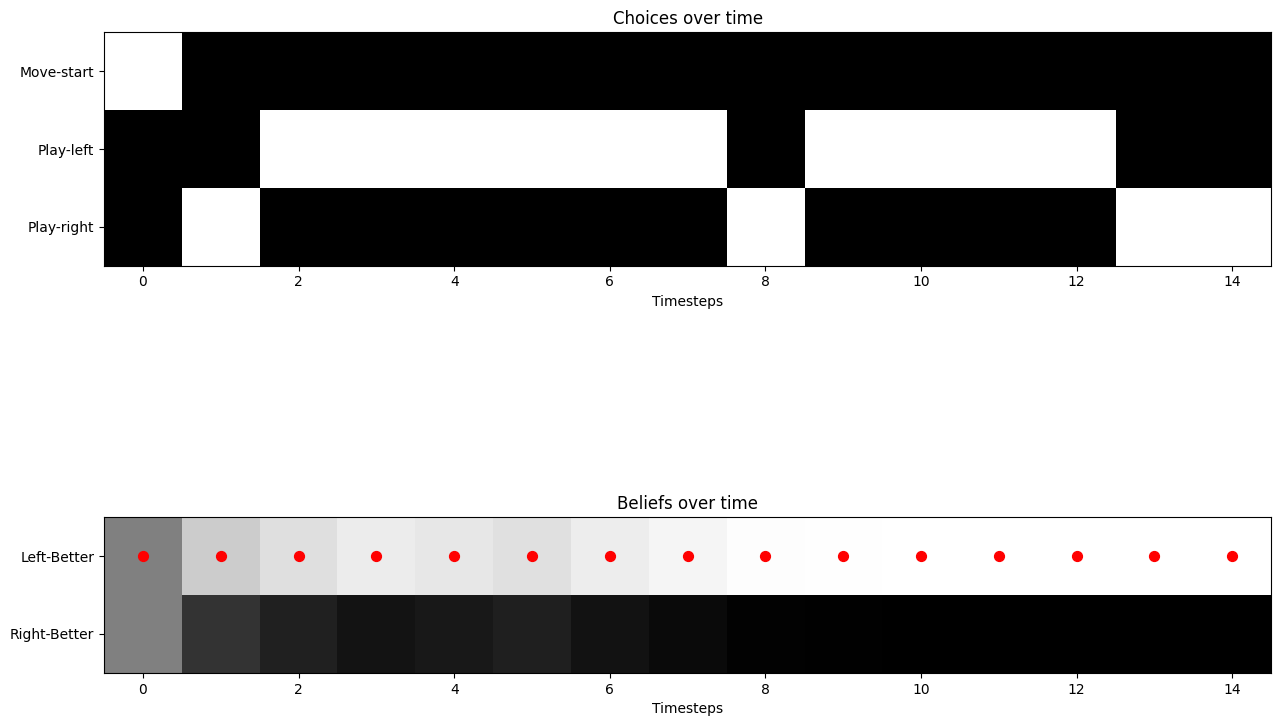

In [49]:
p_reward_env = 0.7 # this is the "true" reward probability - i.e. how often does the better arm actually return a reward, as opposed to a loss. REMEMBER: THIS IS INDEPENDENT OF HOW YOU PARAMETERIZE THE A MATRIX FOR THE REWARD MODALITY
env = TwoArmedBandit(p_reward=p_reward_env)

T = 15

A = create_A(p_reward=0.8)
B = create_B(p_change=0.0)
C = create_C(reward=2.0, pun=-.3)
D = create_D(p_context=0.5)
my_agent = Agent(A = A, B = B, C = C, D = D) # in case you want to re-define the agent, you can run this again
choice_hist, belief_hist, context_hist = run_active_inference_loop(my_agent, env, T = T, verbose = False)
plot_choices_beliefs(choice_hist, belief_hist, context_hist)

# LEarning reward contingencies

In [10]:
A = create_A(p_reward=0.51) # let's assume the agent doesn't know the reward contingencies
pA = utils.dirichlet_like(A, scale = 0.1)

pA[1][0,:,:] *= 10e5 # make the null observation contingencies 'un-learnable'

def parameterize_pA(A_base, scale=1e-16, prior_count=10e5):
  pA = utils.dirichlet_like(A_base, scale = scale)
  pA[1][0,:,:] *= prior_count # make the null observation contingencies 'un-learnable'
  return pA



In [40]:
def run_active_inference_with_learning(my_agent, my_env, T = 5):
  """
  Function that wraps together and runs a full active inference loop using the pymdp.agent.Agent class functionality.
  Also includes learning and outputs the history of the agent's beliefs about the reward
  """

  """ Initialize the first observation """
  obs_label = ["Null", "Start"]  # agent observes itself seeing a `Null` hint, getting a `Null` reward, and seeing itself in the `Start` location
  obs = [reward_obs_names.index(obs_label[0]), choice_obs_names.index(obs_label[1])]

  belief_hist = np.zeros((2, T))
  context_hist = np.zeros(T)

  first_choice = choice_obs_names.index(obs_label[1])
  choice_hist = np.zeros((3,T+1))
  choice_hist[first_choice,0] = 1.0

  dim_qA = (T,) + my_agent.A[my_agent.modalities_to_learn[0]].shape

  qA_hist = np.zeros(dim_qA)

  for t in range(T):
    context_hist[t] = my_env.context_names.index(my_env.context)
    qs = my_agent.infer_states(obs)
    belief_hist[:,t] = qs[0].copy()

    q_pi, efe = my_agent.infer_policies()
    chosen_action_id = my_agent.sample_action()
    # movement_id = int(chosen_action_id[1])

    Q_u = softmax(-efe) # e.g. -G (expected FE)
    movement_id = utils.sample(Q_u[1:]) + 1
        
    choice_hist[movement_id,t+1]= 1.0

    qA_t = my_agent.update_A(obs)
    qA_hist[t] = qA_t[my_agent.modalities_to_learn[0]]

    choice_action = choice_action_names[movement_id]
    obs_label = my_env.step(choice_action)

    # print(f'Observation : Hint: {obs_label[0]}, Reward: {obs_label[1]}, Choice Sense: {obs_label[2]}')
    obs = [reward_obs_names.index(obs_label[0]), choice_obs_names.index(obs_label[1])]

  return choice_hist, belief_hist, qA_hist, context_hist

In [41]:
class TwoArmedBanditStochastic(object):

  def __init__(self, context = None, p_reward = 0.8, p_change = 0.3):

    self.context_names = ["Left-Better", "Right-Better"]

    if context == None:
      self.context = self.context_names[utils.sample(np.array([0.5, 0.5]))] # randomly sample which bandit arm is better (Left or Right)
    else:
      self.context = context

    self.p_reward = p_reward

    self.reward_obs_names = ['Null', 'Loss', 'Reward']

    self.p_change=p_change

  def step(self, action):

    # change the context stochastically at each timestep
    change_or_stay = utils.sample(np.array([self.p_change, 1. - self.p_change])) # TODO: change based on outermost loop in final
    if change_or_stay == 0:
      if self.context == 'Left-Better':
        self.context = 'Right-Better'
      elif self.context == 'Right-Better':
        self.context = 'Left-Better'

    if action == "Move-start":
      observed_reward = "Null"
      observed_choice = "Start"

    elif action == "Play-left":
      observed_choice = "Left Arm"
      if self.context == "Left-Better":
        observed_reward = self.reward_obs_names[utils.sample(np.array([0.0, 1.0 - self.p_reward, self.p_reward]))]
      elif self.context == "Right-Better":
        observed_reward = self.reward_obs_names[utils.sample(np.array([0.0, self.p_reward, 1.0 - self.p_reward]))]

    elif action == "Play-right":
      observed_choice = "Right Arm"
      if self.context == "Right-Better":
        observed_reward = self.reward_obs_names[utils.sample(np.array([0.0, 1.0 - self.p_reward, self.p_reward]))]
      elif self.context == "Left-Better":
        observed_reward = self.reward_obs_names[utils.sample(np.array([0.0, self.p_reward, 1.0 - self.p_reward]))]
    
    obs = [observed_reward, observed_choice]

    return obs
  

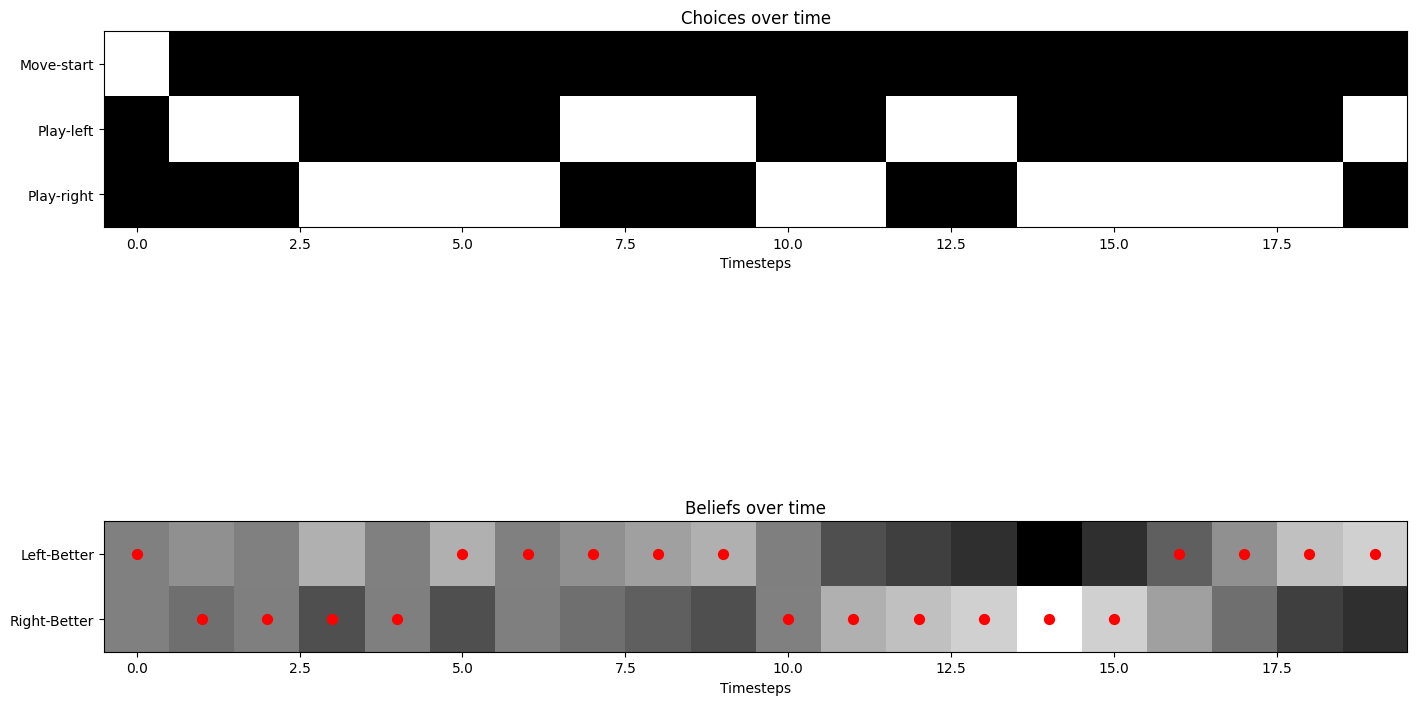

In [51]:
A = create_A(p_reward=0.51) # let's assume the agent doesn't know the reward contingencies
pA = parameterize_pA(A_base=A, scale = 1.0, prior_count=10e5)

B, C, D = create_B(), create_C(reward=2., pun=0), create_D() # the rest of the generative model
env = TwoArmedBanditStochastic(p_reward = 0.8) # initialize the environment with p_reward = 0.7

agent_with_learning = Agent(A=A, pA=pA, B=B, C=C, D=D, modalities_to_learn=[1], lr_pA = 1.0, use_param_info_gain=True, action_selection='deterministic')
T = 20
choice_hist, belief_hist, qA_hist, context_hist = run_active_inference_with_learning(agent_with_learning, env, T = T)
plot_choices_beliefs(choice_hist, belief_hist, context_hist, pad_val = 0.1)

In [23]:
choice_hist

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0.,
        1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1.,
        0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1.,
        0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1.]])

In [14]:
belief_hist

array([[0.5       , 0.50333328, 0.49666672, 0.50333328, 0.49666672,
        0.50333328, 0.49666672, 0.49666672, 0.49666672, 0.49666672,
        0.49666672, 0.49666672, 0.50333328, 0.50333328, 0.49666672,
        0.50333328, 0.49666672, 0.50333328, 0.50333328, 0.50333328,
        0.50333328, 0.49666672, 0.50333328, 0.50333328, 0.50333328],
       [0.5       , 0.49666672, 0.50333328, 0.49666672, 0.50333328,
        0.49666672, 0.50333328, 0.50333328, 0.50333328, 0.50333328,
        0.50333328, 0.50333328, 0.49666672, 0.49666672, 0.50333328,
        0.49666672, 0.50333328, 0.49666672, 0.49666672, 0.49666672,
        0.49666672, 0.50333328, 0.49666672, 0.49666672, 0.49666672]])

In [15]:
# p_reward_beliefs_left = [utils.norm_dist(qa_t)[2,0,2] for qa_t in qA_hist]
# p_reward_beliefs_right = [utils.norm_dist(qa_t)[2,1,2] for qa_t in qA_hist]

# print(f'True context is: {env.context}')
# fig, ax = plt.subplots(figsize=(10,6))
# ax.plot(p_reward_beliefs_left, label = 'Beliefs about $p_{reward}$ when Left Arm is better', lw = 2.0)
# ax.plot(p_reward_beliefs_right, label = 'Beliefs about $p_{reward}$ when Right Arm is better', lw = 2.0)
# ax.set_ylim(-0.05, 1.05)
# ax.set_xlim(0, T)
# ax.legend()